# tsanalytics query configuration

An Query defines a multivariate time series query on the Waylay timeseries database, and can be stored under a name as a Query Configuration.

These Query Configurations can be authored and tested at https://tsa.waylay.io/#/query and by saved name. 

The `analtyics.query` resource in the Waylay Python SDK uses the analytics backend REST services to read, create, update, delete and execute Query Configuration using a standardised JSON representation. 

A JSON definition of Query can also be executed without storing in a Configuration.

## example usage
Import the client and check your backend connections

In [1]:
from waylay import WaylayClient
waylay_client = WaylayClient.from_profile('demo')
# show main info of current token to know the authenticaton status
waylay_client.config.get_valid_token()

<WaylayToken({"tenant": "fa31ec5f-bf6d-4cdb-930f-2cdd38b53e21", "domain": "demo.waylay.io", "subject": "users/dcf8612b-94fa-4cd4-85fb-e66a1724712a", "expires_at": "2020-09-03 00:55:33", "is_valid": true})>

In [2]:
waylay_client.analytics.about.version()

'tsanalytics.server 0.19.4'

... assuming you have previously saved a query under the `151CF-temperature` temperature name ...

`waylay_client.analytics.query.get` fetches the query _definition_.

In [3]:
q_151CF_temp = waylay_client.analytics.query.get('151CF-temperature')
q_151CF_temp

{'data': [{},
  {'metric': 'avgSnr'},
  {'resource': '151D8'},
  {'metric': 'avgSnr', 'resource': '151D8'}],
 'freq': 'P1D',
 'metric': 'temperature',
 'resource': '151CF',
 'aggregation': 'median',
 'interpolation': {'method': 'pad'}}

By default, only the query definition is returned. If you want all metadata, use the `raw` parameter


In [4]:
waylay_client.analytics.query.get('151CF-temperature', raw=True).body

{'messages': [],
 'name': '151CF-temperature',
 'query': {'data': [{},
   {'metric': 'avgSnr'},
   {'resource': '151D8'},
   {'metric': 'avgSnr', 'resource': '151D8'}],
  'freq': 'P1D',
  'metric': 'temperature',
  'resource': '151CF',
  'aggregation': 'median',
  'interpolation': {'method': 'pad'}},
 'meta': {'tags': ['demo'], 'description': 'demo query configuration'},
 'attrs': {'created': '2020-08-29T09:01:34.566657+00:00',
  'created_by': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a',
  'modified': '2020-08-29T09:03:12.225733+00:00',
  'modified_by': 'users/dcf8612b-94fa-4cd4-85fb-e66a1724712a'},
 '_links': {'self': {'href': 'https://ts-analytics.waylay.io/config/query/151CF-temperature'}}}

To execute the saved query, use the `data` operation.

By default, this returns a [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), which render nicely in jupyter notebooks and have built-in support for plots.

In [5]:
df_now = waylay_client.analytics.query.data('151CF-temperature')
df_now.head(5)

resource                        151CF              151D8       
metric                    temperature avgSnr temperature avgSnr
aggregation                    median median      median median
timestamp                                                      
2016-10-04 00:00:00+00:00         NaN    NaN        22.0    NaN
2016-10-05 00:00:00+00:00         NaN    NaN        21.0    NaN
2016-10-06 00:00:00+00:00         NaN    NaN        21.0    NaN
2016-10-07 00:00:00+00:00         NaN    NaN        22.0    NaN
2016-10-08 00:00:00+00:00         NaN    NaN        20.0    NaN

<AxesSubplot:xlabel='timestamp'>

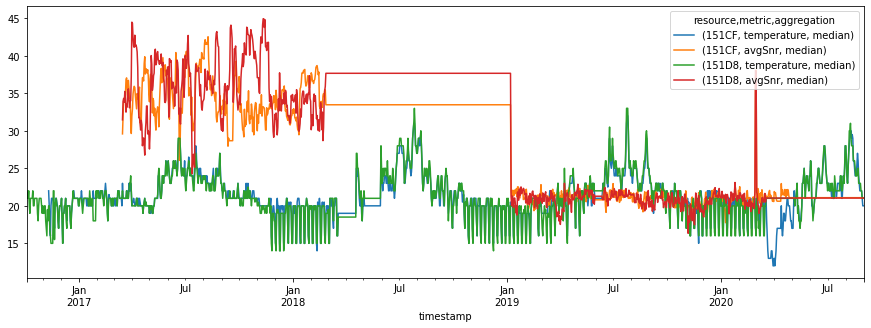

In [6]:
df_now.plot(figsize=(15,5))

You can override parameters of the query definition in a `params` argument.

In [7]:
df_2020_02 = waylay_client.analytics.query.data('151CF-temperature', params={
    'window': 'P100D','until':'2020-02-01'
})
df_2020_02.describe()

resource          151CF                   151D8            
metric      temperature      avgSnr temperature      avgSnr
aggregation      median      median      median      median
count        100.000000  100.000000  100.000000  100.000000
mean          19.785000   20.509700   19.385000   20.463600
std            1.865767    0.875225    1.946059    1.195737
min           15.000000   17.755000   16.000000   16.340000
25%           17.750000   19.848750   18.000000   19.753750
50%           21.000000   20.597500   20.000000   20.730000
75%           21.000000   21.141250   21.000000   21.262500
max           22.000000   22.895000   22.000000   23.110000

<AxesSubplot:xlabel='timestamp'>

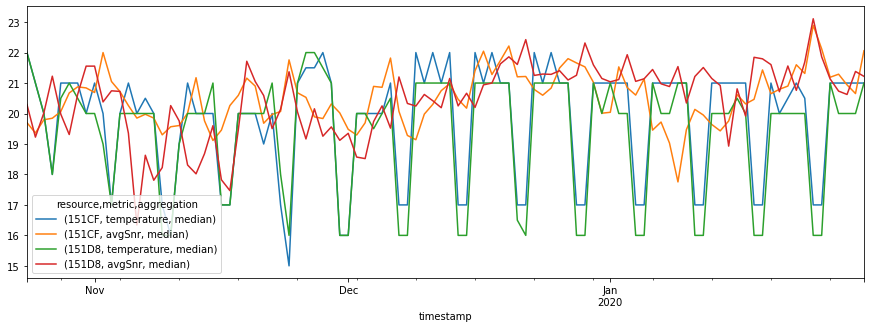

In [8]:
df_2020_02.plot(figsize=(15,5))

You can suppress the conversion to dataframes by setting `response_constructor=False`.

In [9]:
waylay_client.analytics.query.data(
    '151CF-temperature',
    params={'until':'2020-02-01', 'window':'P5D'},
    response_constructor=False
)

[{'columns': ['timestamp',
   {'resource': '151CF', 'metric': 'temperature', 'aggregation': 'median'},
   {'resource': '151CF', 'metric': 'avgSnr', 'aggregation': 'median'},
   {'resource': '151D8', 'metric': 'temperature', 'aggregation': 'median'},
   {'resource': '151D8', 'metric': 'avgSnr', 'aggregation': 'median'}],
  'data': [[1580083200000, 21.0, 21.19, 21.0, 21.134999999999998],
   [1580169600000, 21.0, 21.29, 20.0, 20.735],
   [1580256000000, 21.0, 20.94, 20.0, 20.625],
   [1580342400000, 21.0, 20.655, 20.0, 21.380000000000003],
   [1580428800000, 21.0, 22.06, 21.0, 21.22]],
  'data_axis': 'column',
  'attributes': {'role': 'input'},
  'window_spec': {'from': 1580083200000,
   'until': 1580515200000,
   'window': 'P5D',
   'freq': 'P1D'}}]

You can build your own query config definitions, store them `analytics.query.create`, and execute them.

In [10]:
new_query_cfg_name = '151CF-temperature-demo'
new_query_cfg = { 
    'name': new_query_cfg_name,
    'query': {},
    'meta': { 'description': 'demo, modified version of 151CF-temperature'}
}
new_query = dict(q_151CF_temp)
new_query_cfg['query'] = new_query
new_query['data'] = [ series for series in new_query['data'] if (series.get('metric') != 'lightAmbi') ]
new_query['until'] = '2020-02-01'
new_query['window'] = 'P30D'
new_query_cfg

{'name': '151CF-temperature-demo',
 'query': {'data': [{},
   {'metric': 'avgSnr'},
   {'resource': '151D8'},
   {'metric': 'avgSnr', 'resource': '151D8'}],
  'freq': 'P1D',
  'metric': 'temperature',
  'resource': '151CF',
  'aggregation': 'median',
  'interpolation': {'method': 'pad'},
  'until': '2020-02-01',
  'window': 'P30D'},
 'meta': {'description': 'demo, modified version of 151CF-temperature'}}

We first delete any existing query config under that name

In [11]:
### need to delete any existing query config first
from waylay import RestResponseError
try: 
    waylay_client.analytics.query.remove(new_query_cfg_name)
    print(f"'{new_query_cfg_name}' deleted")
except RestResponseError as exc:
    print(exc)

RestResponseParseError(200: 'Cannot find 'query' in response body.'; DELETE 'https://ts-analytics.waylay.io/config/query/151CF-temperature-demo?api_version=0.19')


In [12]:
waylay_client.analytics.query.create(body=new_query_cfg)

{'data': [{},
  {'metric': 'avgSnr'},
  {'resource': '151D8'},
  {'metric': 'avgSnr', 'resource': '151D8'}],
 'freq': 'P1D',
 'until': '2020-02-01',
 'metric': 'temperature',
 'window': 'P30D',
 'resource': '151CF',
 'aggregation': 'median',
 'interpolation': {'method': 'pad'}}

<AxesSubplot:xlabel='timestamp'>

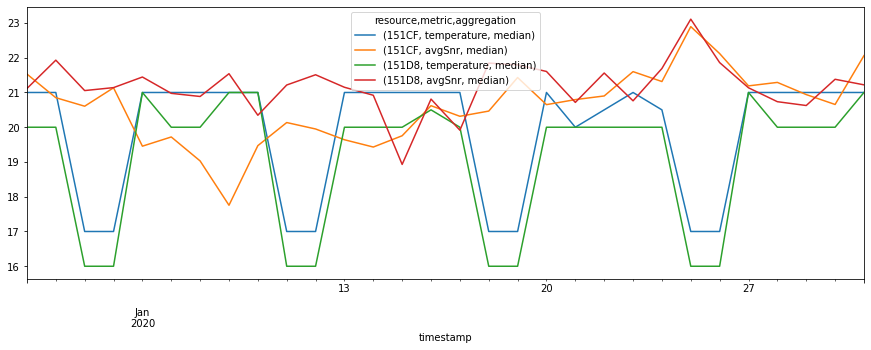

In [13]:
waylay_client.analytics.query.data(new_query_cfg_name).plot(figsize=(15,5))

a query config can be updated (the representation cannot have a name in it then)

<AxesSubplot:xlabel='timestamp'>

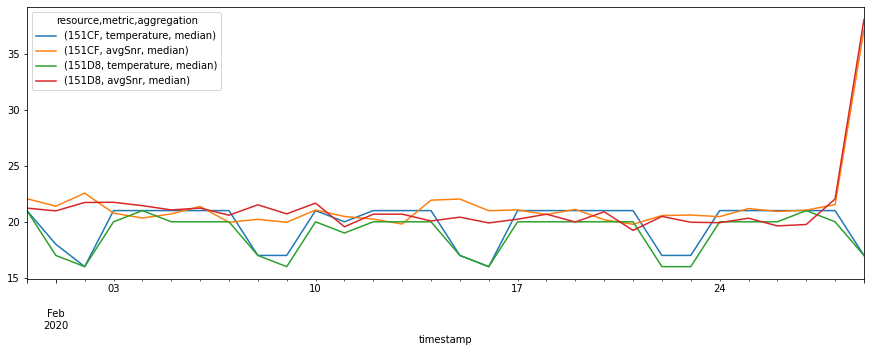

In [14]:
new_query['until'] = '2020-03-01'
waylay_client.analytics.query.replace('151CF-temperature-demo', body={'query': new_query})
waylay_client.analytics.query.data('151CF-temperature-demo').plot(figsize=(15,5))

If a query does not need to be stored, you can use  `analytics.query.execute` to execute a query without saving it as a Query Configuration

In [15]:
waylay_client.analytics.query.execute(body=new_query, params={'window':'P5D'})

resource                        151CF               151D8        
metric                    temperature  avgSnr temperature  avgSnr
aggregation                    median  median      median  median
timestamp                                                        
2020-02-25 00:00:00+00:00        21.0  21.185        20.0  20.320
2020-02-26 00:00:00+00:00        21.0  20.920        20.0  19.635
2020-02-27 00:00:00+00:00        21.0  21.045        21.0  19.760
2020-02-28 00:00:00+00:00        21.0  21.530        20.0  22.040
2020-02-29 00:00:00+00:00        17.0  37.125        17.0  38.040